In [1]:
import json
from Bio import SeqIO, Phylo, Seq
from string import digits
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

In [4]:
def CDS_finder(reference):
    """this function finds CDS location and not CDS location, and saves only those not located at the end of the function"""
    cds_ = dict()
    for feature in reference.features:
        if feature.type == 'CDS': 
            cds_[feature.qualifiers['gene'][0]] = (list(feature.location))
    return(cds_)

ref_file = SeqIO.read("data/areference.gbk", "genbank")

def Synonymous_Mutations(node, dictionary_=None, new_=None):
    """ Finds Synonymous mutations in CDS regions. Input:nested json"""
    gene_cds = CDS_finder(ref_file)
    if new_ is None: new_ = []
    if dictionary_ is None: dictionary_ = dict()
    if 'mutations' in node['branch_attrs']:
        aa_mutations, new_, in_it = ([] for i in range(3))
        if 'nuc' in node['branch_attrs']['mutations']:
            for gene, loc in gene_cds.items():
                if gene in node['branch_attrs']['mutations']:
                    for mut in node['branch_attrs']['mutations'][gene]:
                        aa_mutations.append(int(mut[1:-1])*3+loc[0]) # converting the amino acid location to nucleotide
            for mut in node['branch_attrs']['mutations']['nuc']:
                if '-' not in mut and '*' not in mut and 'N' not in mut and "R" not in mut and "Y" not in mut and "M" not in mut and "D" not in mut:
                    if int(mut[1:-1]) not in aa_mutations and int(mut[1:-1])+2 not in aa_mutations and int(mut[1:-1])+1 not in aa_mutations:  #if the mutation is not in the same codon as a aa mutation
                        new_.append(mut)
                    else: in_it.append(mut[1:-1])
    if 'name' in node:
            dictionary_[node['name']] = new_
    if 'children' in node:
        for child in node['children']:
           Synonymous_Mutations(child, dictionary_, new_=None)
    return(dictionary_)


ref_file = SeqIO.read("data/areference.gbk", "genbank")
with open ("data/rsv_a_genome.json") as file_: f = json.load(file_)  
synonymous = Synonymous_Mutations(f['tree'])

#Extracting all synonymous mutations from json as a list
all_muts = []
for branch, muts in synonymous.items():
    if branch != []:
        for mut in muts:
            if mut[0] and mut[-1] in ["A", "T", "C", "G"]:
                all_muts.append(f'{mut[0]}{mut[-1]}')
all_muts_counter = Counter(all_muts)

#making matrix with mutation rates
df = pd.DataFrame(index=['A', 'C', 'G', 'T'], columns=['A', 'C', 'G', 'T'])      

for mutation, nr in all_muts_counter.items():
    df.at[mutation[0], mutation[-1]] = int(nr)
print("matrix unscaled synonymous")
print(df)


#now have to divide by the nr of locations where the mutation can occur
ref_file = SeqIO.read("data/areference.gbk", "genbank")
gene_cds = CDS_finder(ref_file)

sequence_ref_cds = dict()
whole_seq_CDS = ""
for gene, cds in gene_cds.items(): 
    sequence_ref_cds[gene] = ref_file.seq[cds[0]:cds[-1]]
    whole_seq_CDS = whole_seq_CDS+ref_file.seq[cds[0]:cds[-1]]
#print(whole_seq_CDS)
#whole_seq_CDS = whole_seq_CDS.replace("M", "N")
#whole_seq_CDS = whole_seq_CDS.replace("N", "")
#whole_seq_CDS = whole_seq_CDS.replace("M", "N")

#translation matrix
translations = {'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'], 'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'], 'C': ['TGT', 'TGC'], 'W': ['TGG'], 'E': ['GAA', 'GAG'], 'D': ['GAT', 'GAC'], 'P': ['CCT', 'CCC', 'CCA', 'CCG'], 'V': ['GTT', 'GTC', 'GTA', 'GTG'], 'N': ['AAT', 'AAC'], 'M': ['ATG'], 'K': ['AAA', 'AAG'], 'Y': ['TAT', 'TAC'], 'I': ['ATT', 'ATC', 'ATA'], 'Q': ['CAA', 'CAG'], 'F': ['TTT', 'TTC'], 'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'], 'T': ['ACT', 'ACC', 'ACA', 'ACG'], '*': ['TAA', 'TAG', 'TGA'], 'A': ['GCT', 'GCC', 'GCA', 'GCG'], 'G': ['GGT', 'GGC', 'GGA', 'GGG'], 'H': ['CAT', 'CAC']}


synonymous_possibilities, nonsynonymous_possibilities = (0 for i in range(2))
for gene, sequence in sequence_ref_cds.items():
    for i, letter in enumerate(sequence):
        if i%3 == 0:
            codon = sequence[i: i+3]
            for key, entry in translations.items():
                if codon in entry:
                    synonymous = len(entry)
                    synonymous_possibilities += synonymous-1 
                    nonsynonymous = 9 - len(entry)-1
                    nonsynonymous_possibilities += nonsynonymous

nonsyn_ratio = nonsynonymous_possibilities/(nonsynonymous_possibilities+synonymous_possibilities)
syn_ratio = synonymous_possibilities/(nonsynonymous_possibilities+synonymous_possibilities)

print("\n","syn  fractions")
print(syn_ratio)

print("\n","scaled by syn ratio")
scaled = df.divide(syn_ratio)
scaled = scaled.fillna(0)
print(scaled)

print("\n", "ratio of nt", "\n")
counter = Counter(whole_seq_CDS)
total = 0
for i in counter.values(): total += i

df_ratios = pd.DataFrame.from_dict(counter, orient='index').astype(int).T
df_ratios = df_ratios.divide(total)
print(df_ratios)

nuc = ["A", "C", "G", "T"]
for n in nuc:
    scaled.loc[[n]] = scaled.loc[[n]].div(float(df_ratios[n]))

print(scaled)

print("\n", "normalized and scaled matrix")

sum_ = scaled.to_numpy().sum()
print("sum of all:",  sum_, "\n")

scaled_and_normalized = scaled.divide(sum_)

print(scaled_and_normalized)




matrix unscaled synonymous
      A     C     G     T
A   NaN   249  2342   662
C   589   NaN    28  4079
G  2301    10   NaN   168
T   541  4138   116   NaN

 syn  fractions
0.34887810367869454

 scaled by syn ratio
             A             C            G             T
A     0.000000    713.716331  6712.946371   1897.510887
C  1688.268750      0.000000    80.257258  11691.762702
G  6595.426815     28.663306     0.000000    481.543548
T  1550.684879  11860.876210   332.494355      0.000000

 ratio of nt 

          A         T         G         C         N         M
0  0.358882  0.259638  0.150699  0.164822  0.065883  0.000076
              A             C             G             T
A      0.000000   1988.719467  18705.144547   5287.278262
C  10242.997849      0.000000    486.933684  70935.803441
G  43765.702048    190.202964      0.000000   3195.409798
T   5972.484925  45682.333864   1280.606749      0.000000

 normalized and scaled matrix
sum of all: 207733.6175974809 

          A

A    0.125070
C    0.393127
G    0.226980
T    0.254824
dtype: float64
{1: 0.22697970292575742, 2: 0.3520492153921362, 3: 0.5790289183178936, 4: 0.806008621243651, 5: 0.9310781337100298, 6: 1.0561476461764085, 7: 1.1812171586427873, 8: 1.5743443564364057, 9: 1.967471554230024, 10: 2.3605987520236424, 11: 2.6154223388378877, 12: 3.0085495366315063, 13: 3.401676734425125, 14: 3.526746246891504, 15: 3.9198734446851224, 16: 4.174697031499368, 17: 4.567824229292986, 18: 4.692893741759365, 19: 4.817963254225743, 20: 5.211090452019362, 21: 5.6042176498129805, 22: 5.729287162279359, 23: 6.122414360072978, 24: 6.515541557866596, 25: 6.7703651446808415, 26: 7.16349234247446, 27: 7.556619540268079, 28: 7.783599243193836, 29: 7.908668755660215, 30: 8.033738268126594, 31: 8.260717971052351, 32: 8.487697673978108, 33: 8.880824871771726, 34: 9.13564845858597, 35: 9.26071797105235, 36: 9.515541557866595, 37: 9.908668755660212, 38: 10.163492342474457, 39: 10.288561854940836, 40: 10.413631367407215, 41:

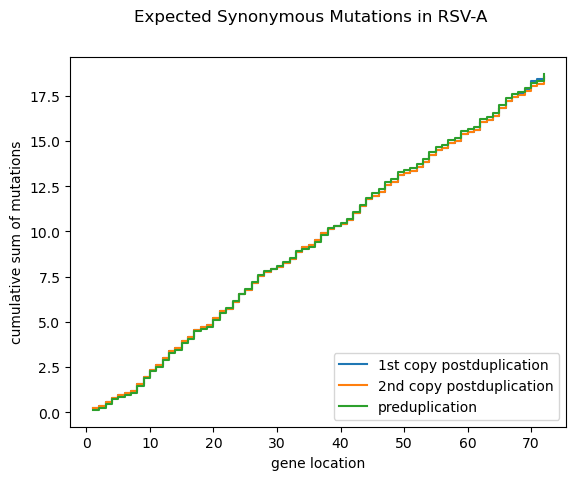

In [43]:
sum_of_rows = scaled_and_normalized.sum(axis = 1)
print(sum_of_rows)
tree_file  = Phylo.read("data/a_tree.nwk", "newick")
tree_file.root_at_midpoint()
tree_file.find_clades()
total_len = tree_file.total_branch_length()
duplication_file = SeqIO.parse("data/last_reconstruction.fasta", "fasta")
seq_dict = dict()
for record in duplication_file:
    seq_dict[record.id] = record.seq
for branch in tree_file.get_nonterminals(order='preorder'):
    if pd.isna(branch.name) == False:
        if '-'*int(72) not in seq_dict[branch.name]:
            first_dupl_sequence = seq_dict[branch.name]
            with_dupl = branch.total_branch_length()
            break  
for branch in tree_file.get_nonterminals(order='preorder'):
    if pd.isna(branch.name) == False:
            first_predupl_sequence = seq_dict[branch.name][72:]
            break  
without_dupl = total_len-with_dupl


post_dupl_1 = first_dupl_sequence[:72]
post_dupl_2 = first_dupl_sequence[72:]


cumulative_1, cumulative_2, cumulative_pre = (dict() for i in range(3))
cumulative = 0
for i, character in enumerate(post_dupl_1):
    cumulative+= sum_of_rows[character]
    cumulative_1[i+1] =cumulative

cumulative = 0
for i, character in enumerate(post_dupl_2):
    cumulative+= sum_of_rows[character]
    cumulative_2[i+1] =cumulative

cumulative = 0
for i, character in enumerate(first_predupl_sequence):
    cumulative+= sum_of_rows[character]
    cumulative_pre[i+1] =cumulative
    

print(cumulative_1)
print(cumulative_2)
print(cumulative_pre)
#axs = plt.plot()
plt.step(cumulative_1.keys(), cumulative_1.values(), label= f'1st copy postduplication', where='post')
plt.step(cumulative_2.keys(), cumulative_2.values(), label=f'2nd copy postduplication', where='post' )
plt.step(cumulative_pre.keys(), cumulative_pre.values(), label= f'preduplication', where='post' )
plt.legend(loc='lower right')
plt.suptitle('Expected Synonymous Mutations in RSV-A')
plt.xlabel("gene location")
plt.ylabel("cumulative sum of mutations")
plt.savefig("expected_synonymous.png")